In [1]:
from pearl.pearl_initial_formulation import *
from datastructures.graphutils import flatten_tree
from datastructures.api import (edges_no_param, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor)
from datastructures.graphutils import all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.transformations import transform_components
from copy import deepcopy

In [2]:
#nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

In [3]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [4]:
not_input = [r'\omega_0', 'E_{move}', 'A_{33}', 'B_M', 'K_G', 'I', 'E_{recharge}', 'm_{struct}']
not_output = ['D_f', 'D_d', 'D_s', 't_s', 't_f', 't_d', 'P_{comms}', 'R'] #R
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [5]:
outset_opt = {right:left for left, right in edges_left_right if (left,right) 
              in edges_left_right and xsol[left, right] > 0.5}

In [6]:
outset_opt = None

In [7]:
tree_for_reformulation = flatten_tree(tree, 'opt')
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', mdf=False)
edges_minassign_noparam = edges_no_param(model, edges_minassign)

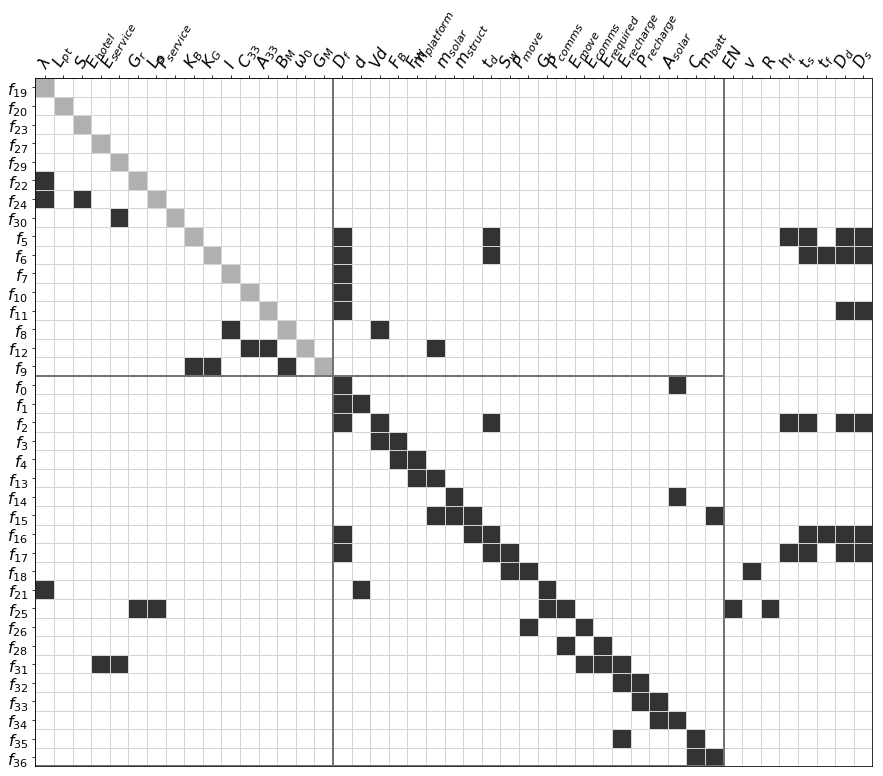

In [8]:
render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, figsize=(15,15));

In [9]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

## Add optimization problem to model

In [10]:
opt = addsolver(m, name="opt", idbyname=True)
addobj(opt, mtot) # for optimization make sure to add OPT in model
addineq(opt, hf-0.9*tf)
addineq(opt, Ds-0.9*Df)
addineq(opt, 0.1-P_move)
addineq(opt, Ds-0.9*Dd)
addineq(opt, 50-Pcomms)
#{tf:[0,10], ts:[0,10], Ds:[0,10], Dd:[0,10], hf:[0,10]}
solvefor = [v, EN, hf, tf, ts, Ds, Dd]
varoptions = {v:[0.1,10], EN:[0.1,100], hf:[0.1,10], tf:[0.1,10], ts:[0.1,10], 
              Ds:[0.1,10], Dd:[0.1,10]}
varoptions.update({elt: [0] for elt in tree_minassign[2].keys()})
#solvefor = [tf, ts, td, Ds, Dd, Df]
#varoptions = {tf:[0.1,10], ts:[0.1,10], td:[0.1,10], Ds:[0.1,10], Dd:[0.1,10], Df:[0.1,10]}
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT}

In [11]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)

In [12]:
edges_ma_opt_nopar = edges_no_param(model, edges_ma_opt)

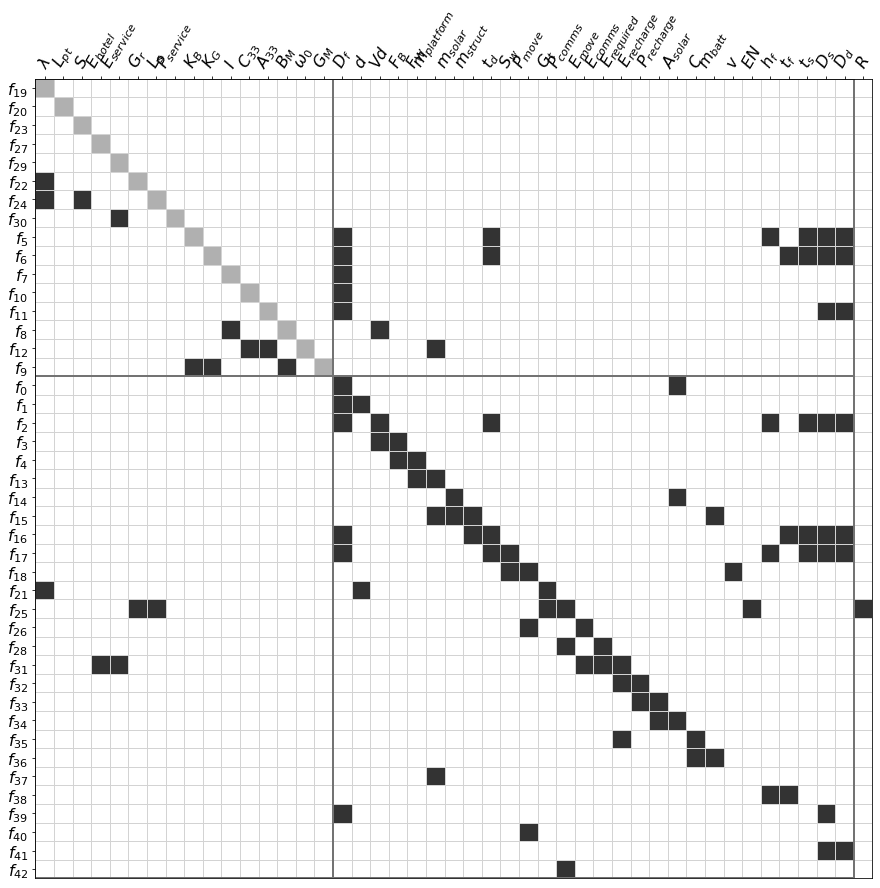

In [13]:
render_incidence(edges_ma_opt_nopar, tree_ma_opt, rawvarname=True, figsize=(15,15));

In [14]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [15]:
#prob.set_val('P_comms', 50)

# Initial guesses

In [16]:
prob.set_val('alpha', 0.2)
prob.set_val('t_f',0.15)
prob.set_val('t_s',0.2)
prob.set_val('t_d',0.2)
prob.set_val('D_f', 3.713)
prob.set_val('D_s', 0.1)
prob.set_val('D_d', 1.)

In [17]:
prob.run_model()

In [19]:
prob.run_driver()

C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.EN', inds=[0])] have no impact on the constraints or objective.
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: [1966.80852649]
            Iterations: 26
            Function evaluations: 67
            Gradient evaluations: 26
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------


True

In [18]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals'])

----------------
Design Variables
----------------
name        val              size  lower  upper  
----------  ---------------  ----  -----  ----- 
D_f         [3.713]          1     0.0    1e+30  
d           [0.05788463]     1     0.0    1e+30  
Vd          [2.65807285]     1     0.0    1e+30  
F_B         [26691.0810773]  1     0.0    1e+30  
F_W         [26691.0810773]  1     0.0    1e+30  
m_platform  [2720.80337179]  1     0.0    1e+30  
m_solar     [10.]            1     0.0    1e+30  
m_struct    [2609.80337179]  1     0.0    1e+30  
t_d         [0.2]            1     0.0    1e+30  
S_w         [11.20931312]    1     0.0    1e+30  
P_move      [7649.23527112]  1     0.0    1e+30  
G_t         [0.97811926]     1     0.0    1e+30  
P_comms     [897.68772926]   1     0.0    1e+30  
E_move      [7.64923527]     1     0.0    1e+30  
E_comms     [897.68772926]   1     0.0    1e+30  
E_required  [11.646923]      1     0.0    1e+30  
E_recharge  [11.646923]      1     0.0    1e+30  
